### Trajectory analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

import geopandas as gpd
import shapely
import skmob
from skmob.measures.individual import jump_lengths
from skmob.tessellation import tilers
from skmob.preprocessing import detection, clustering
from skmob.preprocessing import filtering


pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)
import warnings
warnings.simplefilter("ignore")
import os

In [3]:
""" pre-processing
    sorting the event data frame by user ID and then by time is the most critical step.
"""
os.chdir('/Users/joshwinnes/Library/Mobile Documents/com~apple~CloudDocs/Wheaton College/fall 2024/topics in data science/data')
events = pd.read_csv("Galapagos Tortoise Movement Ecology Programme_2009-2018.csv", sep=',', parse_dates=[2])
new_cols = pd.Series(events.columns.values).str.replace(pat = r"[-:]", repl="_", regex=True)
tortoise = events.set_axis(labels = new_cols, axis =1)
tortoise.drop(tortoise.index[tortoise["manually_marked_outlier"].notna()], inplace = True)
tortoise.drop(columns =["manually_marked_outlier"], inplace=True)
tortoise.drop(index = tortoise.index[tortoise.isna().any(axis=1)], inplace=True)
cols = ['event_id', 'timestamp', 'location_long', 'location_lat',
       'eobs_temperature', 'ground_speed', 'heading', 'height_above_ellipsoid',
       'individual_local_identifier', 'individual_taxon_canonical_name']
tortoise.drop(columns=tortoise.columns.difference(cols), inplace=True)

tortoise.insert(loc = 2, column = "timestamp_UTC",
                value = tortoise['timestamp'].apply(lambda x: x.tz_localize(tz='UTC'))
                )
tortoise.insert(loc = 3, column = "timestamp_local", 
                value = tortoise["timestamp_UTC"].apply(lambda x: x.tz_convert(tz='US/Pacific'))
                )
tortoise.sort_values(by = ["individual_local_identifier", "timestamp_local"], inplace=True)
tortoise.insert(loc = 4, column = "minute_diff", 
                value = tortoise.groupby(['individual_local_identifier'])["timestamp_local"].diff()\
                    .apply(lambda x: x/np.timedelta64(1, 'm')).fillna(0).astype('int64')
                    )
tortoise['year'] = tortoise["timestamp_local"].dt.year
tortoise['month'] = tortoise["timestamp_local"].dt.month
tortoise['date'] = tortoise["timestamp_local"].dt.date
tortoise.reset_index(drop=True, inplace=True)

After all the pre-processing, we make geometry objects and trajectory objects.

In [4]:
tortoise_gdf = gpd.GeoDataFrame(tortoise)
tortoise_gdf["geometry"] = gpd.points_from_xy(tortoise_gdf.location_long, tortoise_gdf.location_lat)
tortoise_trajectory = skmob.TrajDataFrame(tortoise, latitude='location_lat', longitude='location_long', \
    user_id='individual_local_identifier', datetime='timestamp_local', \
)

We will add jump length into the event dataframe and trajectory data frame.

In [5]:
tortoise_jl = jump_lengths(tortoise_trajectory)
tortoise_jl["jump_lengths"] = \
    tortoise_jl["jump_lengths"].apply(
        lambda x: np.append(x,np.nan).tolist())
tortoise_jl = tortoise_jl.explode(["jump_lengths"],
                ignore_index=True).reset_index(drop=True)
tortoise["jump_length"] = tortoise_jl.jump_lengths
tortoise_trajectory["jump_length"] = tortoise_jl["jump_lengths"]

100%|██████████| 96/96 [00:05<00:00, 16.12it/s]


 - get Alison data for experiment

In [6]:
alison = tortoise[tortoise["individual_local_identifier"] == "Alison"]
alison_gdf = tortoise_gdf[tortoise_gdf["individual_local_identifier"] == "Alison"]
alison_trajectory = tortoise_trajectory.query("uid == 'Alison'")

In [7]:
map_f = alison_trajectory.query("year == 2012").plot_trajectory(zoom=14, start_end_markers=False, max_points = 50000, weight=1, opacity=0.9,hex_color='#883399', tiles = "OpenStreetMap")
alison_trajectory.query("year == 2013").plot_trajectory(map_f=map_f, start_end_markers=False, max_points = 50000, weight=1, opacity=0.9,hex_color='#66c066')
alison_trajectory.query("year == 2014").plot_trajectory(map_f=map_f, start_end_markers=False, max_points = 50000, weight=1, opacity=0.9,hex_color='#ff800c')
alison_trajectory.query("year == 2015").plot_trajectory(map_f=map_f, start_end_markers=False, max_points = 50000, weight=1, opacity=0.9,hex_color='#60ff78')
alison_trajectory.query("year == 2016").plot_trajectory(map_f=map_f, start_end_markers=False, max_points = 50000, weight=1, opacity=0.9,hex_color='#301e4b')
map_f


In [8]:
map_f.save("alison_by_year.html")


## Tesselation as Region-of-Interest (RoI)

Next, we explore spatial tesselation to create a disjoint partition of the whole region into region-of-interest (RoI) using geometric shapes called tiles. 

First, we need to choose the map system we want to us for base map, and get the base map of the area we want to tessellate. Let's use OpenStreetMap and choose the main island, which has the place name of "Isla Santa Cruz, Galapagos, Ecuador" in OpenStreetMap.

<Axes: >

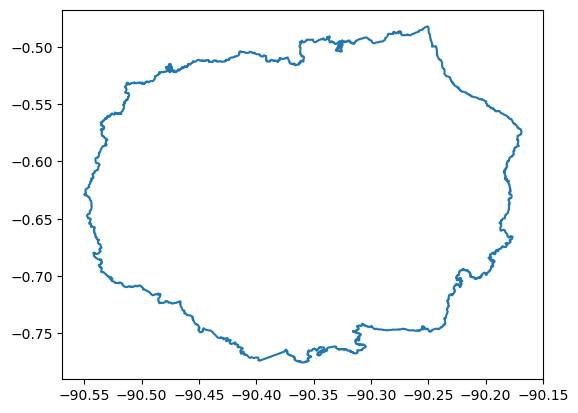

In [10]:
import osmnx as ox
place_name = "Isla Santa Cruz, Galapagos, Ecuador"
santa_cruz_gdf = ox.geocode_to_gdf(place_name)
santa_cruz_gdf.boundary.plot()

In [11]:
tessellation = tilers.tiler.get("h3_tessellation", 
                base_shape=santa_cruz_gdf,meters =500)

In [12]:
tessellation.head(3)

,geometry,H3_INDEX,tile_ID
0,"POLYGON ((-90.28433 -0.53766, -90.28863 -0.540...",614395641939886079,0
1,"POLYGON ((-90.4834 -0.5599, -90.48769 -0.56276...",614395806939611135,1
2,"POLYGON ((-90.35419 -0.64221, -90.35848 -0.645...",614395808086753279,2


Each of the rows in the resultant dataframe is a polygon, with geometry, h3_index, and an ID.

In [13]:
tessellation.dtypes

geometry    geometry
H3_INDEX      uint64
tile_ID       object
dtype: object

We can plot the boundary of the hexagons.

<Axes: >

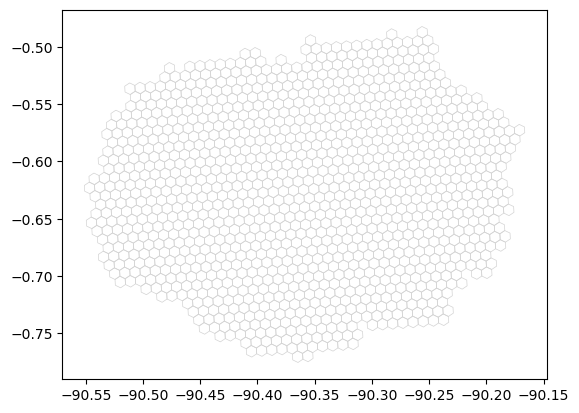

In [14]:
tessellation["geometry"].boundary.plot(color="lightgrey", linewidth=0.5)

We can use any geopandas data frame as base map for tessellation, such as Alison's trajectory data.

<Axes: >

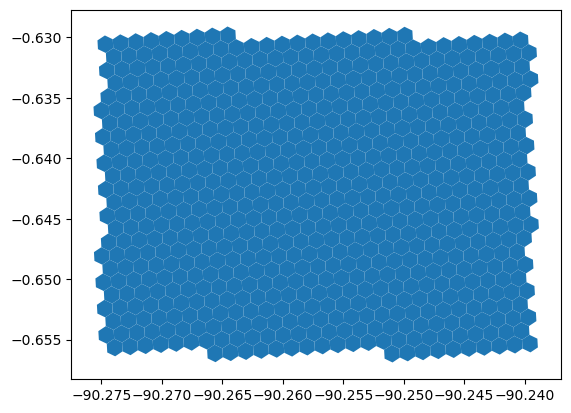

In [15]:
alison_tessellation = tilers.tiler.get("h3_tessellation", 
                    base_shape=alison_gdf,meters =50)
alison_tessellation.plot()


In [16]:
shapely.area(tessellation["geometry"].geometry[0])

6.78260075069077e-05

Basically, a tesselation data frame contains the geometry of the hexagons that cover the area, along with their H3_index. 

 H3 is a discrete global grid system for indexing geographies into a hexagonal grid, developed at Uber, and is opensourced. https://www.uber.com/blog/h3/ 



We can pick the first two polygons and calculate the Hausdorff distance between them:

In [17]:
tessellation.iloc[0].geometry.hausdorff_distance(tessellation.iloc[1].geometry)

0.20030613473528253

We can also visualize what the hexagons look like using `matplotlib`, highlighting the first two polygons in red:

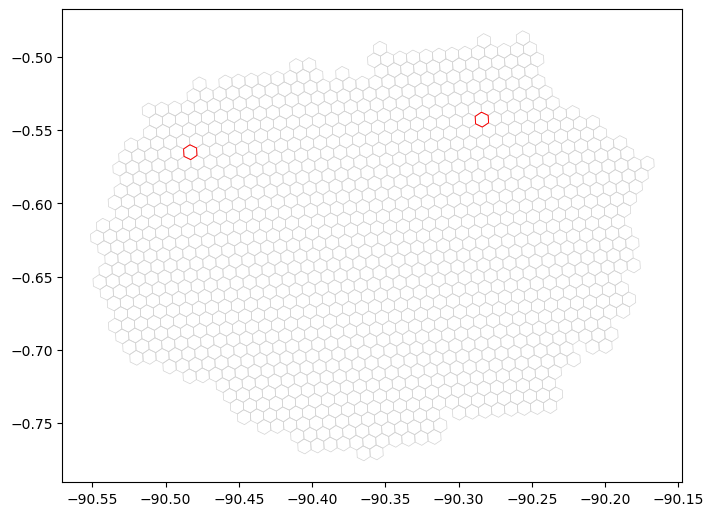

In [18]:
fig, ax = plt.subplots(figsize = (8,8))
tessellation.geometry.boundary.plot(color="lightgrey", ax=ax, linewidth=0.5)
tessellation.iloc[['0','1']].geometry.boundary.plot(color="r", ax=ax,linewidth=0.7)
plt.show()

We can take a look at two adjacent hexagons.

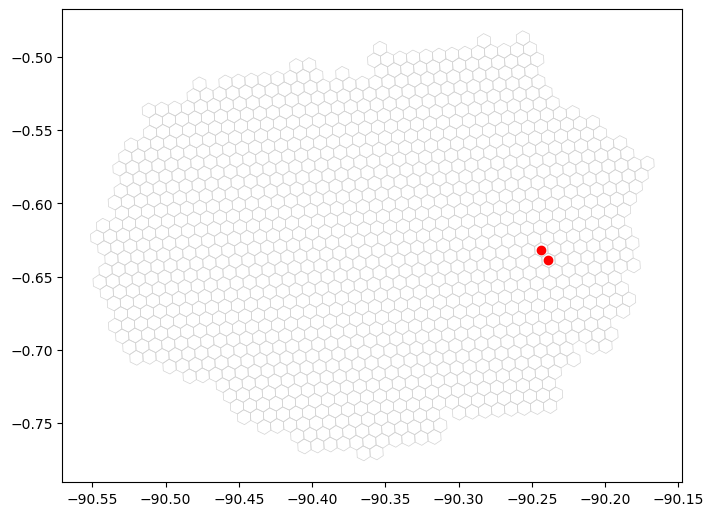

In [19]:
fig, ax = plt.subplots(figsize = (8,8))
tessellation["geometry"].boundary.plot(color="lightgrey", ax=ax, linewidth=0.5)
tessellation.query("tile_ID == '221' or tile_ID =='411'")["geometry"].centroid.plot(color="red", ax=ax)  # for meter = 500 tessellation, the two cells touch eath other
plt.show()

<Axes: >

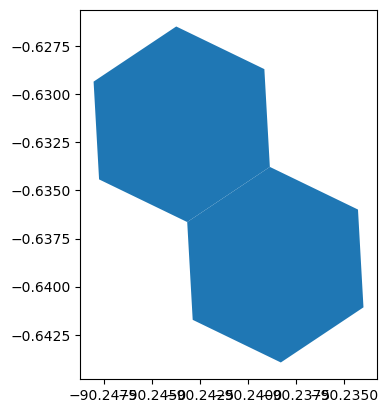

In [20]:
tessellation.query("tile_ID == '221' or tile_ID == '411'").plot()

Compare the Hausdorff distance for these consecutive polygons to the Hausdorff distance for the previous two polygons.

Hausdorff distance is the greatest of all the distances from a point in one set to the closest point in the other set. (i.e., max of min)

In [21]:
two_hexagon = tessellation.query("tile_ID == '221' or tile_ID == '411'")
two_hexagon.iloc[0].geometry.hausdorff_distance(two_hexagon.iloc[1].geometry)

0.008769453529132422

## Mapping Trajectories into Tesselation

We can map our `tortoise_trajectory` dataframe from earlier into the tessellation using `skmob`. This assigns each event in the trajectory dataframe to the corresponding tile in the tessellation.

In [27]:
tortoise_trajectory_mapping = tortoise_trajectory.mapping(tessellation)
tortoise_trajectory_mapping.head(3)

TypeError: sjoin() got an unexpected keyword argument 'op'

In [23]:
tortoise_trajectory_mapping.shape

NameError: name 'tortoise_trajectory_mapping' is not defined

Notice how each event now has an associated 'tile_ID'.

As before, there are close to 1.8 million events. We can reduce this number by dropping all events with duplicate 'date' and 'tile_ID' values.

In [ ]:
tortoise_trajectory_mapping_deduped = tortoise_trajectory_mapping.drop_duplicates(
        subset=["uid", "date", "tile_ID"], keep = 'first'
    )
tortoise_trajectory_mapping_deduped.shape[0]/tortoise.shape[0]

This reduces the number of events to about 3% of the original.

Let's map the trajectories for Alison to the tessellation:

In [ ]:
alison_trajectory_mapping = tortoise_trajectory_mapping.query("uid == 'Alison'")
alison_trajectory_mapping.shape

We can drop duplicates here as well, resulting in roughly an 8% reduction.

In [ ]:
alison_trajectory_mapping_deduped = alison_trajectory_mapping.drop_duplicates(
    subset=["uid", "date", "tile_ID"], keep = 'first'
    )
alison_trajectory_mapping_deduped.shape[0]/alison.shape[0]

Here is what the trajectory mapping for Alison looks like:

In [ ]:
alison_trajectory_mapping_deduped.head(3)

### deduping by date is actually not quite right
 - the zig-zag portion will be remvoed as such

In [ ]:
tortoise_trajectory.shape, tortoise_trajectory_mapping.shape, tortoise_trajectory_mapping_deduped.shape

In [ ]:
tortoise_trajectory.plot_trajectory(start_end_markers= False, tiles = 'OpenStreetMap')

In [ ]:
tortoise_trajectory_mapping_deduped.plot_trajectory(tiles = 'OpenStreetMap')

In [ ]:
alison_trajectory_mapping_deduped.plot_trajectory(tiles = 'OpenStreetMap')

 - reduced to 6% of events when meter = 500 for tesselation
 - reduced to 9% when meter = 50
 - reduced to 13% when meter = 20

This shows the reduction at 500 meter resolution is too coarse. We should increase the resolution for this study.
H3 hierarchy is set by resolution levels:

* resolution 7 -> 1000 meters -> 166 tiles for the whole santa cruz island
* resolution 8 -> 500 meters -> 1177 tiles for the whole santa cruz island
* resolution 9 -> 200 meters -> 8241 tiles for the whole santa cruz island
* resolution 10 -> 100 meters -> 57734 tiles for the whole santa cruz island



let's increase the resolution, to resolution 9, meters = 200.

In [ ]:
tessellation = tilers.tiler.get("h3_tessellation", 
                base_shape=santa_cruz_gdf,meters =200)
tessellation["tile_lng"] = tessellation.geometry.centroid.x
tessellation["tile_lat"] = tessellation.geometry.centroid.y
tortoise_trajectory_mapping = tortoise_trajectory.mapping(tessellation)
tortoise_trajectory_mapping_deduped = tortoise_trajectory_mapping.merge(tessellation, 
    on = "tile_ID", how = "inner")\
    .drop_duplicates(subset=["uid","date", "tile_ID"])
tortoise_trajectory_mapping_deduped.sort_values(
    by = ["uid", "datetime"], inplace=True)
tortoise_trajectory_mapping_deduped.shape[0]/ tortoise_trajectory.shape[0]

We can make a new trajectory usign the mapped tessellations' lat long. We first drop the original trajectory's lat/lng so that we can create new trajectory using the tiles' lat long

In [ ]:
tortoise_trajectory_mapping_deduped_trajectory = skmob.TrajDataFrame( \
    tortoise_trajectory_mapping_deduped.drop(columns =["lat","lng"]),
    #tortoise_trajectory_mapping_deduped, 
    latitude='tile_lat', longitude='tile_lng', \
    user_id='uid', datetime='datetime', \
    )


In [ ]:
tortoise_trajectory_mapping_deduped_trajectory.plot_trajectory(tiles = "OpenStreetMap")

In [ ]:
alison_trajectory_mapping_deduped_trajectory = tortoise_trajectory_mapping_deduped_trajectory.query("uid == 'Alison'")
alison_trajectory_mapping_deduped_trajectory.plot_trajectory()


This looks better, trajectory reduction by tessellation mapping depends on the tessellation resolution, too coarse resolution may not produce desirable results.

In [ ]:
alison_trajectory_mapping_deduped = tortoise_trajectory_mapping_deduped.query("uid == 'Alison'")
alison_trajectory_mapping_deduped.plot_trajectory(tiles = "OpenStreetMap")


Still, plotting with the original lat long produce smoother lines.

In [ ]:
alison_trajectory_mapping_deduped.shape,alison_trajectory_mapping_deduped_trajectory.shape

## Trajectory compression

We use scikit-mobility's preprocessing compression function can be used to reduce the size of trajectory. 

It takes a parameter spatial_radius_km, by which, all points within a radius of spatial_radius_km kilometers from a given initial point are compressed into a single point. The function assigns the median coordinates of all points as the coordinates of the replacement point, the time of the initial point as the time of the replacement point.

In [ ]:
from skmob.preprocessing import compression
tortoise_trajectory_compressed = compression.compress(
    tortoise_trajectory, spatial_radius_km=0.02)
tortoise_trajectory_compressed.plot_trajectory(tiles = 'OpenStreetMap')


In [ ]:
alison_trajectory_compressed = tortoise_trajectory_compressed.query("uid == 'Alison'")
alison_trajectory_compressed.plot_trajectory(tiles = "OpenStreetMap")

In [ ]:
tortoise_trajectory_compressed.shape[0]/tortoise_trajectory.shape[0], alison_trajectory_compressed.shape[0]/alison_trajectory.shape[0]

## Stay locaitons and stay clusters

Recall we looked at "stay locations" in last section, we can do a quick comparison.

stop_radius_factor is only useful if we don't specify "spatial_radius_km" in the stay locaiton function, in which case, the function uses “spatial_radius_km” from preprocessing.compression function  stop_radius_factor as the value for parameter "spatial_radius_km".

In [ ]:
tortoise_stay_location = detection.stay_locations(tortoise_trajectory, 
    minutes_for_a_stop=400,
    spatial_radius_km=0.05, leaving_time=True)
alison_stay_location = tortoise_stay_location.query("uid == 'Alison'")
tortoise_stay_location.shape[0]/tortoise.shape[0], \
    alison_stay_location.shape[0]/alison_trajectory.shape[0]

We can see the reduction is significant.

From the plot of stay locaitons in relation to the original trajectory, we can see stay locations are not fully aligned on the trajectory lines, this is because we stay points took the median of coordinates of the original points.

In [ ]:
alison_plot = alison_trajectory.plot_trajectory(zoom=14, tiles="OpenStreetMap")
alison_stay_location.plot_stops(map_f = alison_plot, radius = 3)
alison_plot


### Stay clusters

In [ ]:
tortoise_stay_cluster = clustering.cluster(
    tortoise_stay_location, 
    cluster_radius_km=0.1, min_samples=1)
alison_stay_cluster = tortoise_stay_cluster.query("uid == 'Alison'")
tortoise_stay_cluster.shape[0]/tortoise_trajectory.shape[0], \
    alison_stay_cluster.shape[0]/alison_trajectory.shape[0]

In [ ]:
alison_stay_cluster.groupby("cluster").date.nunique()

In [ ]:
start_year = 2010
end_year = 2020
year_list = range(start_year, end_year)
month_date_str = '05-01'
s_date = []
for i in range(start_year, end_year+1):
    s_date.append(pd.Timestamp(str(i)+'-' +month_date_str).tz_localize(tz = 'US/Pacific'))
e_date = s_date[1:]
s_date.pop()
pal = sns.color_palette('tab10')
color_list = pal.as_hex()

In [ ]:
color_list

In [ ]:
alison_plot = alison_trajectory.plot_trajectory(zoom=14, tiles="OpenStreetMap")
alison_stay_cluster[alison_stay_cluster["cluster"] == 0].plot_stops(map_f = alison_plot, hex_color = color_list[0], zoom=14, radius = 4)
alison_stay_cluster[alison_stay_cluster["cluster"] == 1].plot_stops(map_f = alison_plot, hex_color = color_list[1], radius =4)
alison_stay_cluster[alison_stay_cluster["cluster"] == 2].plot_stops(map_f = alison_plot, hex_color = color_list[2], radius = 4)
alison_stay_cluster[alison_stay_cluster["cluster"] == 3].plot_stops(map_f = alison_plot, hex_color = color_list[3], radius = 4)
alison_plot

## Movement diaries


In [ ]:
user = "Alison"
start_datetime = pd.to_datetime('2010-05-01 030000').tz_localize(tz='US/Pacific')
end_datetime = pd.to_datetime('2019-05-31 030000').tz_localize(tz='US/Pacific')
tortoise_stay_cluster.plot_diary(user, start_datetime=start_datetime, end_datetime=end_datetime,legend=True)


In [ ]:
s_date

In [ ]:
alison_segment = []
for i, j in zip(s_date,e_date):
    alison_segment.append(alison_trajectory[(alison_trajectory["datetime"] >= i) & (alison_trajectory["datetime"] < j)])

In [ ]:
m = alison_segment[0].plot_trajectory(hex_color = color_list[0], zoom=14)
alison_segment[1].plot_trajectory(map_f = m,hex_color = color_list[1], weight = 1)
alison_segment[2].plot_trajectory(map_f = m,hex_color = color_list[2])
alison_segment[3].plot_trajectory(map_f = m,hex_color = color_list[3])
alison_segment[4].plot_trajectory(map_f = m,hex_color = color_list[4])
alison_segment[5].plot_trajectory(map_f = m,hex_color = color_list[5])
alison_segment[6].plot_trajectory(map_f = m,hex_color = color_list[6])
alison_segment[7].plot_trajectory(map_f = m,hex_color = color_list[7])
m


In [ ]:
alison_stay_segment = []
for i, j in zip(s_date,e_date):
    alison_stay_segment.append(alison_stay_location[(alison_stay_location["datetime"] >= i) & (alison_stay_location["datetime"] < j)])

In [ ]:
m = alison_segment[0].plot_trajectory(hex_color = color_list[0], zoom=14)
alison_segment[1].plot_trajectory(map_f = m,hex_color = color_list[1])
alison_segment[2].plot_trajectory(map_f = m,hex_color = color_list[2])
alison_segment[3].plot_trajectory(map_f = m,hex_color = color_list[3])
alison_segment[4].plot_trajectory(map_f = m,hex_color = color_list[4])
alison_segment[5].plot_trajectory(map_f = m,hex_color = color_list[5])
alison_segment[6].plot_trajectory(map_f = m,hex_color = color_list[6])
alison_segment[7].plot_trajectory(map_f = m,hex_color = color_list[7])
alison_stay_segment[0].plot_stops(map_f = m, radius = 5, hex_color = color_list[0])
alison_stay_segment[1].plot_stops(map_f = m, radius = 5, hex_color = color_list[1])
alison_stay_segment[2].plot_stops(map_f = m, radius = 5, hex_color = color_list[2])
alison_stay_segment[3].plot_stops(map_f = m, radius = 5, hex_color = color_list[3])
alison_stay_segment[4].plot_stops(map_f = m, radius = 5, hex_color = color_list[4])
alison_stay_segment[5].plot_stops(map_f = m, radius = 5, hex_color = color_list[5])
alison_stay_segment[6].plot_stops(map_f = m, radius = 5, hex_color = color_list[6])
alison_stay_segment[7].plot_stops(map_f = m, radius = 5, hex_color = color_list[7])
m

In [ ]:
date_20121001 = pd.Timestamp('2012-10-01').tz_localize(tz = 'US/Pacific')
date_20121231 = pd.Timestamp('2012-12-31').tz_localize(tz = 'US/Pacific')
date_20131001 = pd.Timestamp('2013-10-01').tz_localize(tz = 'US/Pacific')
date_20131231 = pd.Timestamp('2013-12-31').tz_localize(tz = 'US/Pacific')
s1 = alison_stay_location[(alison_stay_location['datetime'] >= date_20121001) & (alison_stay_location['datetime'] <= date_20121231)]
s2 = alison_stay_location[(alison_stay_location['datetime'] >= date_20131001) & (alison_stay_location['datetime'] <= date_20131231)]
from geopy.distance import geodesic as GD
coordinates1 = list(zip(s1.lat, s1.lng))
coordinates2 = list(zip(s2.lat, s2.lng))
dist_list = []
for p1, p2 in zip(coordinates1, coordinates2):
    dist_list.append(GD(p1,p2).km)
plt.plot(dist_list)

## compute pairwise distance between trajectory segments

In [ ]:
date_20121001 = pd.Timestamp('2012-10-01').tz_localize(tz = 'US/Pacific')
date_20121231 = pd.Timestamp('2012-12-31').tz_localize(tz = 'US/Pacific')
date_20131001 = pd.Timestamp('2013-10-01').tz_localize(tz = 'US/Pacific')
date_20131231 = pd.Timestamp('2013-12-31').tz_localize(tz = 'US/Pacific')
s1 = alison_trajectory[(alison_trajectory['datetime'] >= date_20121001) & (alison_trajectory['datetime'] <= date_20121231)]
s2 = alison_trajectory[(alison_trajectory['datetime'] >= date_20131001) & (alison_trajectory['datetime'] <= date_20131231)]
from geopy.distance import geodesic as GD
coordinates1 = list(zip(s1.lat, s1.lng))
coordinates2 = list(zip(s2.lat, s2.lng))
dist_list = []
for p1, p2 in zip(coordinates1, coordinates2):
    dist_list.append(GD(p1,p2).km)
row = []
matrix = []
for i in coordinates1:
    for j in coordinates2:
        row.append(round(GD(i,j).km, 4))
    matrix.append(row)
    row = []
sns.heatmap(np.flip(np.array(matrix),axis=0))

In [ ]:
date_20121001 = pd.Timestamp('2012-10-01').tz_localize(tz = 'US/Pacific')
date_20121231 = pd.Timestamp('2012-12-31').tz_localize(tz = 'US/Pacific')
date_20131001 = pd.Timestamp('2013-09-01').tz_localize(tz = 'US/Pacific')
date_20131231 = pd.Timestamp('2013-12-31').tz_localize(tz = 'US/Pacific')
s1 = alison_trajectory[(alison_trajectory['datetime'] >= date_20121001) & (alison_trajectory['datetime'] <= date_20121231)]
s2 = alison_trajectory[(alison_trajectory['datetime'] >= date_20131001) & (alison_trajectory['datetime'] <= date_20131231)]
from geopy.distance import geodesic as GD
coordinates1 = list(zip(s1.lat, s1.lng))
coordinates2 = list(zip(s2.lat, s2.lng))
dist_list = []
for p1, p2 in zip(coordinates1, coordinates2):
    dist_list.append(GD(p1,p2).km)
row = []
matrix = []
for i in coordinates1:
    for j in coordinates2:
        row.append(round(GD(i,j).km, 4))
    matrix.append(row)
    row = []
sns.heatmap(np.flip(np.array(matrix),axis=1))

In [ ]:
sns.heatmap(np.array(matrix))

In [ ]:
date_20121001 = pd.Timestamp('2012-10-01').tz_localize(tz = 'US/Pacific')
date_20121231 = pd.Timestamp('2012-12-31').tz_localize(tz = 'US/Pacific')
date_20130901 = pd.Timestamp('2013-09-01').tz_localize(tz = 'US/Pacific')
date_20141231 = pd.Timestamp('2014-12-31').tz_localize(tz = 'US/Pacific')
s1 = alison_trajectory[(alison_trajectory['datetime'] >= date_20121001) & (alison_trajectory['datetime'] <= date_20121231)]
s2 = alison_trajectory[(alison_trajectory['datetime'] >= date_20130901) & (alison_trajectory['datetime'] <= date_20141231)]
from geopy.distance import geodesic as GD
coordinates1 = list(zip(s1.lat, s1.lng))
coordinates2 = list(zip(s2.lat, s2.lng))
dist_list = []
for p1, p2 in zip(coordinates1, coordinates2):
    dist_list.append(GD(p1,p2).km)
row = []
matrix = []
for i in coordinates1:
    for j in coordinates2:
        row.append(round(GD(i,j).km, 4))
    matrix.append(row)
    row = []
sns.heatmap(np.flip(np.array(matrix),axis=1))

In [ ]:
sns.heatmap(np.flip(np.array(matrix),axis=0))

In [ ]:
plt.plot(np.array(matrix[10]))

In [ ]:
s1.shape,s2.shape

In [ ]:
alison_stay_location.plot(x="datetime", y ="lng")

## Back to migration study

Overlay the month variable on lat long plot to see how changes in months correlate with changes in lat long. We plot something similar as below but used ground speed as hue in last lecture. Perhaps months correlate better with migration because the speed range is too small to reveal the difference visually. 

In [ ]:
plt.figure(figsize = (20,5))
alison = tortoise.query("individual_local_identifier == 'Alison' and ground_speed <1") # ground_speed unit is meters per second
sns.scatterplot(alison, x = "timestamp_local", y="location_long", hue="month")

In [ ]:
plt.figure(figsize = (20,5))
alison = tortoise[tortoise["individual_local_identifier"] == "Alison"]
sns.scatterplot(alison, x = "timestamp_local", y="location_lat", hue = "month")
plt.show()

Jump length does not help either due to outlier jump length, we would need to clean out the outlier because we can see. 

In [ ]:
plt.figure(figsize = (20,5))
alison = tortoise.query("individual_local_identifier == 'Alison' and ground_speed <1") # ground_speed unit is meters per second
sns.scatterplot(alison, x = "timestamp_local", y="location_long", hue="jump_length")

In [ ]:
user = "Christian"
start_datetime = pd.to_datetime('2010-05-01 030000').tz_localize(tz='US/Pacific')
end_datetime = pd.to_datetime('2019-05-31 030000').tz_localize(tz='US/Pacific')
tortoise_stay_cluster.plot_diary(user, start_datetime=start_datetime, end_datetime=end_datetime,legend=True)

## using tesspy package to generate tessellation

Another way to generate a tessellation is using package `tesspy`, which can be used in combination with scikit-mobility. 
For the tessellation from "tesspy" to work with the skmob functions that use tessellation, we need to add a column named "tile_ID"

"tesspy" works better for our current study, because we can specify the island name directly and get a tessellation of Santa Cruz Island using hexagons. It also allows for a specification of resolution, whcih skmob does not support. 


In [ ]:
from tesspy import Tessellation
tessellation_tesspy = Tessellation("isla santa cruz").hexagons(resolution=9)
tessellation_tesspy.head()

In [ ]:
tessellation_tesspy.dtypes

We don't have the tile_ID as from scikit-mobility's tessellation, and the hex_id is in hex, whereas the h3_index in scikit-mobility's tessellation is actual integers. 

Thus, to use this tessellation for scikit-mobility, we need to add a tile_ID column. We don't have to have the exact tile_ID to hex_index match. Or we can just change the column name hex_id to tile_ID.

In [ ]:
tessellation_tesspy.reset_index(names = ["tile_ID"], inplace=True)
tessellation_tesspy["tile_lng"] = tessellation_tesspy.geometry.centroid.x
tessellation_tesspy["tile_lat"] = tessellation_tesspy.geometry.centroid.y

In [ ]:
fig, ax = plt.subplots(figsize = (8,8))
tessellation_tesspy["geometry"].boundary.plot(color="lightgrey", ax=ax, linewidth=0.5)
tessellation_tesspy.query("tile_ID == 221 or tile_ID == 411")["geometry"].centroid.plot(color="red", ax=ax)  # for meter = 500 tessellation, the two cells touch eath other
plt.show()

Note that the tile IDs no longer match the same location as we had seen in scikit-mobility's tessellation. But if we compare the H3-index from the two tessellation, they are the same set. 

In [ ]:
type(tessellation_tesspy["geometry"][0])

In [ ]:
tessellation_tesspy["geometry"][0].area

In [ ]:
tessellation_tesspy["geometry"].explore(color="blue", linewidth=0.3)

We can verify that the first record in tessellation_tesspy is also in the tessellation produced by scikit-mobility function. tessellation_tesspy used hex string, and scikit-mobility tessellation used the integer value of the hex index.

In [ ]:
tessellation[tessellation["H3_INDEX"]==int(tessellation_tesspy.iloc[0].hex_id, 16)]

In [ ]:
tessellation_tesspy.shape, tessellation.shape

### POI data from OpenStreetMap

In [ ]:
road_graph = ox.graph_from_place('Isla Santa Cruz', )
ox.plot_graph(road_graph, bgcolor = "green")


In [ ]:
nodes, edge = ox.graph_to_gdfs(road_graph)
nodes.head()

In [ ]:
edge.head()

In [ ]:
place_name = "Isla Santa Cruz, Galapagos, Ecuador"
place_gdf = ox.geocode_to_gdf(place_name)

place_gdf.plot(color = "lightgrey")

In [ ]:
tessellation_tesspy.iloc[221]["geometry"]

In [ ]:
tessellation_tesspy.iloc[221]["geometry"].area*1000*1000 # area unit is square meters

In [ ]:
tessellation_tesspy.iloc[0].geometry.hausdorff_distance(tessellation.iloc[3].geometry)

In [ ]:
tessellation_tesspy.iloc[221]["geometry"].bounds

In [ ]:
[tessellation_tesspy.iloc[221].geometry.centroid.x, tessellation_tesspy.iloc[221].geometry.centroid.y]